# First trials and explorations with DCGAN
Making use of this implem from pfnet: https://github.com/mattya/chainer-DCGAN

### generated dataset

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
!ls ../../data

TestImages.txt
TrainImages.txt
Training_IDs of interesting algo for exit rule opt_2016_04_11.csv
^o^.txt
bad_ones.csv
by_sharpe_ratio.csv
chainer-DCGAN
correct_list_user_training.csv
danboorugrab.py
detect.py
faces
faces2
faces3
faces_all
indoorCVPR_09.tar
japanese_clothes+tall.txt
lbpcascade_animeface.xml
list_user_training.csv
pretrain.h5
test


In [3]:
from IPython import display

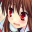

In [30]:
display.Image("../../data/faces_all/00bbb4dc486add71aa912970279b1258_0.png")

In [5]:
import os

In [31]:
image_dir = "../../data/faces_all/"
l = os.listdir(image_dir)

In [32]:
!rm ../../data/faces_all/.DS_Store

rm: cannot remove '../../data/faces_all/.DS_Store': No such file or directory


In [33]:
imagefiles = [os.path.join("../../data/faces_all/", f) for f in os.listdir("../../data/faces_all/") if os.path.isfile(os.path.join("../../data/faces_all/", f))]

In [35]:
len(imagefiles)

4275

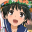

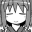

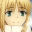

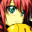

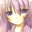

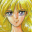

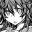

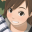

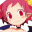

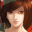

In [36]:
for i in imagefiles[-10:]: 
    display.display(display.Image(i))

In [11]:
import pickle
import numpy as np
from PIL import Image
import os
from StringIO import StringIO
import math
import pylab


import chainer
from chainer import computational_graph
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Variable
from chainer.utils import type_check
from chainer import function

import chainer.functions as F
import chainer.links as L


import numpy

In [28]:
# image_dir = './images'
out_image_dir = './out_images'
out_model_dir = './out_models'


nz = 100          # # of dim for Z
# batchsize=100
# n_epoch=10000
# n_train=200000
# image_save_interval = 50000
batchsize=100
n_epoch=2
n_train=5
image_save_interval = 1

# read all images

In [37]:
fs = os.listdir(image_dir)
print(len(imagefiles))
dataset = []
for fl in imagefiles:
    f = open(fl, 'rb')
    img_bin = f.read()
    dataset.append(img_bin)
    f.close()
print(len(dataset))

4275
4275


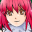

In [14]:
display.Image("../../data/faces_all/e0f3ed6991a9ec766d8335299c654848_0.png")

In [15]:
for idxi,i in enumerate(fs):
    if i == "e0f3ed6991a9ec766d8335299c654848_0.png":
        print(idxi)

1283


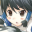

In [16]:
display.Image(dataset[0])

In [17]:
class ELU(function.Function):

    """Exponential Linear Unit."""
    # https://github.com/muupan/chainer-elu

    def __init__(self, alpha=1.0):
        self.alpha = numpy.float32(alpha)

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 1)
        x_type, = in_types

        type_check.expect(
            x_type.dtype == numpy.float32,
        )

    def forward_cpu(self, x):
        y = x[0].copy()
        neg_indices = x[0] < 0
        y[neg_indices] = self.alpha * (numpy.exp(y[neg_indices]) - 1)
        return y,

    def forward_gpu(self, x):
        y = cuda.elementwise(
            'T x, T alpha', 'T y',
            'y = x >= 0 ? x : alpha * (exp(x) - 1)', 'elu_fwd')(
                x[0], self.alpha)
        return y,

    def backward_cpu(self, x, gy):
        gx = gy[0].copy()
        neg_indices = x[0] < 0
        gx[neg_indices] *= self.alpha * numpy.exp(x[0][neg_indices])
        return gx,

    def backward_gpu(self, x, gy):
        gx = cuda.elementwise(
            'T x, T gy, T alpha', 'T gx',
            'gx = x >= 0 ? gy : gy * alpha * exp(x)', 'elu_bwd')(
                x[0], gy[0], self.alpha)
        return gx,


def elu(x, alpha=1.0):
    """Exponential Linear Unit function."""
    # https://github.com/muupan/chainer-elu
    return ELU(alpha=alpha)(x)

In [18]:
paraAAA = 6 # 6
paraBBB = 6 # 6
paraIN = 6 # 6

class Generator(chainer.Chain):
    def __init__(self):
        super(Generator, self).__init__(
            l0z = L.Linear(nz, paraIN*paraIN*512, wscale=0.02*math.sqrt(nz)),
            dc1 = L.Deconvolution2D(512, 256, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*512)),
            dc2 = L.Deconvolution2D(256, 128, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*256)),
            dc3 = L.Deconvolution2D(128, 64, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*128)),
            dc4 = L.Deconvolution2D(64, 3, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*64)),
            bn0l = L.BatchNormalization(paraAAA*paraAAA*512),
            bn0 = L.BatchNormalization(512),
            bn1 = L.BatchNormalization(256),
            bn2 = L.BatchNormalization(128),
            bn3 = L.BatchNormalization(64),
        )
        
    def __call__(self, z, test=False):
        h = F.reshape(F.relu(self.bn0l(self.l0z(z), test=test)), (z.data.shape[0], 512, paraBBB, paraBBB))
        h = F.relu(self.bn1(self.dc1(h), test=test))
        h = F.relu(self.bn2(self.dc2(h), test=test))
        h = F.relu(self.bn3(self.dc3(h), test=test))
        x = (self.dc4(h))
        return x



class Discriminator(chainer.Chain):
    def __init__(self):
        super(Discriminator, self).__init__(
            c0 = L.Convolution2D(3, 64, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*3)),
            c1 = L.Convolution2D(64, 128, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*64)),
            c2 = L.Convolution2D(128, 256, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*128)),
            c3 = L.Convolution2D(256, 512, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*256)),
            l4l = L.Linear(paraAAA*paraAAA*512, 2, wscale=0.02*math.sqrt(paraAAA*paraAAA*512)),
            bn0 = L.BatchNormalization(64),
            bn1 = L.BatchNormalization(128),
            bn2 = L.BatchNormalization(256),
            bn3 = L.BatchNormalization(512),
        )
        
    def __call__(self, x, test=False):
        h = elu(self.c0(x))     # no bn because images from generator will katayotteru?
        h = elu(self.bn1(self.c1(h), test=test))
        h = elu(self.bn2(self.c2(h), test=test))
        h = elu(self.bn3(self.c3(h), test=test))
        l = self.l4l(h)
        return l

In [40]:
image_dimension = 96 # 96

def clip_img(x):
    return np.float32(-1 if x<-1 else (1 if x>1 else x))

def train_dcgan_labeled(gen, dis, epoch0=0):
    o_gen = optimizers.Adam(alpha=0.0002, beta1=0.5)
    o_dis = optimizers.Adam(alpha=0.0002, beta1=0.5)
    o_gen.setup(gen)
    o_dis.setup(dis)
    o_gen.add_hook(chainer.optimizer.WeightDecay(0.00001))
    o_dis.add_hook(chainer.optimizer.WeightDecay(0.00001))

    zvis = (xp.random.uniform(-1, 1, (100, nz), dtype=np.float32))
    
    for epoch in xrange(epoch0,n_epoch):
#         print(">>> start epoch", epoch)
        perm = np.random.permutation(n_train)
        sum_l_dis = np.float32(0)
        sum_l_gen = np.float32(0)
        
        for i in xrange(0, n_train, batchsize):
            # discriminator
            # 0: from dataset
            # 1: from noise

#             print("load image start ", i)
            x2 = np.zeros((batchsize, 3, image_dimension, image_dimension), dtype=np.float32)
            for j in range(batchsize):
                try:
                    rnd = np.random.randint(len(dataset))
                    rnd2 = np.random.randint(2)
                    imaa = Image.open(StringIO(dataset[rnd])).resize((96,96),resample=Image.NEAREST)
                    img = np.asarray(imaa.convert('RGB')).astype(np.float32).transpose(2, 0, 1)
                    if rnd2==0:
                        x2[j,:,:,:] = (img[:,:,::-1]-128.0)/128.0
                    else:
                        x2[j,:,:,:] = (img[:,:,:]-128.0)/128.0
#                     print('No error', rnd2,rnd, fs[rnd])
                except NotImplementedError:
                    print('read image error occured', rnd2,rnd, fs[rnd])
#             print("load image done")
            
            # train generator
            z = Variable(xp.random.uniform(-1, 1, (batchsize, nz), dtype=np.float32))
            x = gen(z)
            yl = dis(x)
            L_gen = F.softmax_cross_entropy(yl, Variable(xp.zeros(batchsize, dtype=np.int32)))
            L_dis = F.softmax_cross_entropy(yl, Variable(xp.ones(batchsize, dtype=np.int32)))
            
            # train discriminator
                    
            x2 = Variable(cuda.to_gpu(x2))
            yl2 = dis(x2)
            L_dis += F.softmax_cross_entropy(yl2, Variable(xp.zeros(batchsize, dtype=np.int32)))
            
#             print("forward done")

            o_gen.zero_grads()
            L_gen.backward()
            o_gen.update()
            
            o_dis.zero_grads()
            L_dis.backward()
            o_dis.update()
            
            sum_l_gen += L_gen.data.get()
            sum_l_dis += L_dis.data.get()
            
#             print("backward done")

#             if i%image_save_interval==0:
        if epoch%image_save_interval==0 or epoch==n_epoch:
#             print("at epoch",epoch)
            pylab.rcParams['figure.figsize'] = (16.0,16.0)
            pylab.clf()
            vissize = 100
            z = zvis
            z[50:,:] = (xp.random.uniform(-1, 1, (50, nz), dtype=np.float32))
            z = Variable(z)
            x = gen(z, test=True)
            x = x.data.get()
            for i_ in range(100):
                tmp = ((np.vectorize(clip_img)(x[i_,:,:,:])+1)/2).transpose(1,2,0)
                pylab.subplot(10,10,i_+1)
                pylab.imshow(tmp)
                pylab.axis('off')
            pylab.savefig('%s/vis_%d_%d.png'%(out_image_dir, epoch,i))

            serializers.save_hdf5("%s/dcgan_model_dis_%d.h5"%(out_model_dir, epoch),dis)
            serializers.save_hdf5("%s/dcgan_model_gen_%d.h5"%(out_model_dir, epoch),gen)
            serializers.save_hdf5("%s/dcgan_state_dis_%d.h5"%(out_model_dir, epoch),o_dis)
            serializers.save_hdf5("%s/dcgan_state_gen_%d.h5"%(out_model_dir, epoch),o_gen)
        print('epoch', epoch, sum_l_gen/n_train, sum_l_dis/n_train)


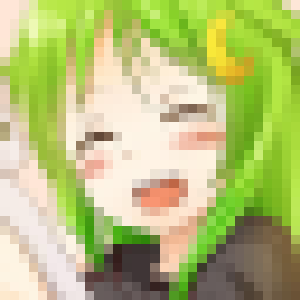

In [20]:
ima = Image.open(StringIO(dataset[48]))
ima.resize((300,300),resample=Image.NEAREST)

In [22]:
xp = cuda.cupy
cuda.get_device(3).use()

In [23]:
try:
    os.mkdir(out_image_dir)
    os.mkdir(out_model_dir)
except:
    print("exist")

exist


In [24]:
gen = Generator()
dis = Discriminator()
gen.to_gpu()
dis.to_gpu()

In [25]:
%%time
batchsize=250
n_epoch=500
n_train=2000
image_save_interval = 100

train_dcgan_labeled(gen, dis)

>>> start epoch 0
< epoch end 0 0.0150363807678 0.00681693172455
>>> start epoch 1
< epoch end 1 0.0391708679199 0.0169427223206
>>> start epoch 2
< epoch end 2 0.0415089950562 0.027700750351
>>> start epoch 3
< epoch end 3 0.0782261428833 0.00850219154358
>>> start epoch 4
< epoch end 4 0.0685461883545 0.0213869686127
>>> start epoch 5
< epoch end 5 0.0629954109192 0.0166819534302
>>> start epoch 6
< epoch end 6 0.114353897095 0.0050504617691
>>> start epoch 7
< epoch end 7 0.0969009628296 0.00955663108826
>>> start epoch 8
< epoch end 8 0.0885562973022 0.00918209838867
>>> start epoch 9
< epoch end 9 0.0738726882935 0.0035905714035
>>> start epoch 10
< epoch end 10 0.0941873092651 0.00421168470383
>>> start epoch 11
< epoch end 11 0.12662008667 0.00556816005707
>>> start epoch 12
< epoch end 12 0.0776033172607 0.00614638710022
>>> start epoch 13
< epoch end 13 0.120412246704 0.00301687288284
>>> start epoch 14
< epoch end 14 0.088421295166 0.00344009113312
>>> start epoch 15
< epoch 

In [26]:
%%time
# batchsize=100
# n_epoch=10000
# n_train=200000
# image_save_interval = 50000
batchsize=250
n_epoch=2000
n_train=10000
image_save_interval = 20

train_dcgan_labeled(gen, dis)

>>> start epoch 0
< epoch end 0 2.56979942322 0.220902442932
CPU times: user 16.1 s, sys: 784 ms, total: 16.9 s
Wall time: 16.9 s


In [39]:
%%time
# batchsize=100
# n_epoch=10000
# n_train=200000
# image_save_interval = 50000
batchsize=250
n_epoch=2000
n_train=10000
image_save_interval = 20

train_dcgan_labeled(gen, dis)

at epoch 0
CPU times: user 15.3 s, sys: 416 ms, total: 15.7 s
Wall time: 15.7 s


---